# Multitaper spectral analysis


### Issue

Neural data are non-stationary, while many common time-series analyses assume stationarity. Analyzing short time windows (within which stationarity may hold) provides one solution to this issue, however, this method introduces both bias and variance in the spectral estimation.

### Solution

The multitaper method was designed to address the issues of bias and variance in spectral estimation. This method leverages multiple orthogonol tapers known as discrete prolate spheroidal sequences (dpss) or Slepian sequences. These tapers are designed to optimize the trade-off between narrowband and broadband bias. Furthermore, by averaging mulitple spectral estimates for each time window, the variance of the estimation is reduced. 

### Related Work

The following papers include discussion of this topic:

- [A Review of Multitaper Spectral Analysis](https://pubmed.ncbi.nlm.nih.gov/24759284/), Babadi and Brown, 2014
- [Comparison of spectral analysis methods for characterizing brain oscillations](https://pubmed.ncbi.nlm.nih.gov/17292478/), van Vugt et al., 2007
- [Spectrum Estimation and Harmonic Analysis](https://ieeexplore.ieee.org/document/1456701), Thompson, 1982

### Related Discussion / Examples

The following examples discuss related topics:
-  Mike X Cohen covers multitapers in Chapter 16 of Analyzing Neural Time Series Data: [book](https://direct.mit.edu/books/book/4013/Analyzing-Neural-Time-Series-DataTheory-and), [lecture](https://mikexcohen.com/lecturelets/multitaper/multitaper.html), [associated matlab code](https://github.com/mikexcohen/AnalyzingNeuralTimeSeries/blob/main/chapter16.m), [python translation](https://github.com/lyndond/Analyzing_Neural_Time_Series/blob/master/notebooks/chapter16.ipynb)
- MNE compares several time-frequency estimation methods (Multitaper vs. Morlet vs. Stockwell vs. Hilbert) in this [example](https://mne.tools/stable/auto_examples/time_frequency/time_frequency_simulated.html). 

In [1]:
# Imports
from IPython.display import Image
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.signal.windows import dpss
from mne.time_frequency import (tfr_array_multitaper, tfr_array_morlet, stft,
                                stftfreq)

from neurodsp.utils import create_times, set_random_seed
from specparam.utils.data import interpolate_spectra

### Settings

In [2]:
# Set random seed
set_random_seed(0)

### Multitaper method overview

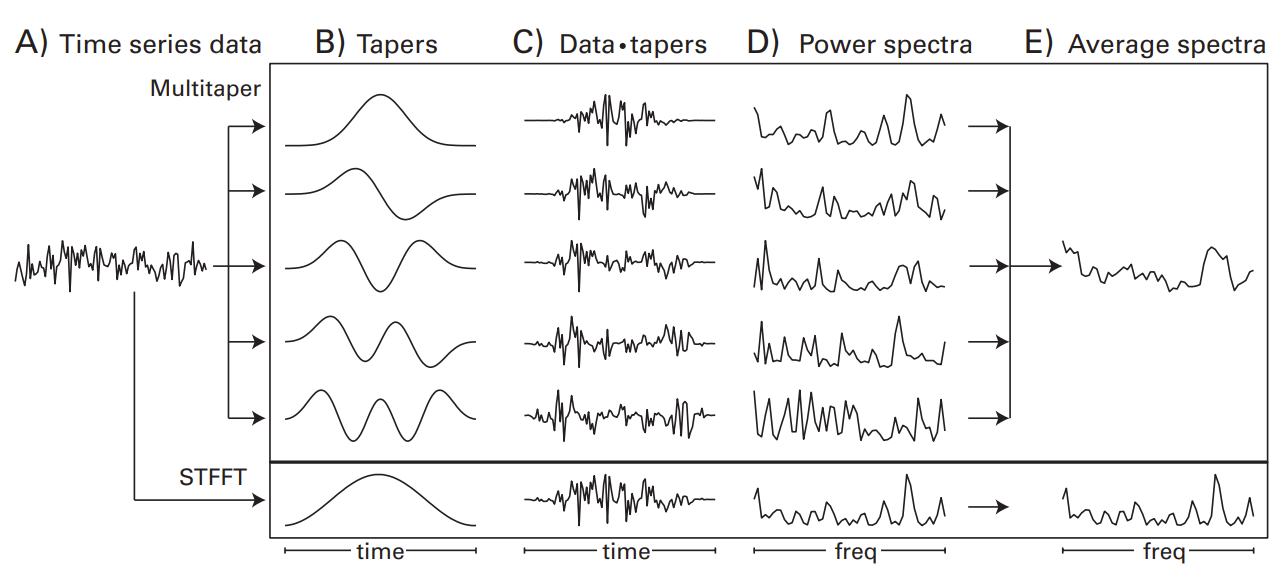

In [3]:
Image(filename='images/cohen_2014_multitaper.png')

### Load example neural data

In [4]:
# load data

# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indices.
fname = "../data/ecog_data.mat"
data_in = loadmat(fname)
sta = data_in['sta'].flatten() # Standard event
tar = data_in['tar'].flatten() # Target event
resp = data_in['resp'].flatten() # Response times
data = data_in['data'].flatten() # Neural data from one ECoG channel
n_seconds = len(data) / fs

# print details
print(f"N seconds: {n_seconds}")
print(f"N standard stimuli: {len(sta)}")
print(f"N target stimuli: {len(tar)}")
print(f"N response times: {len(resp)}")

N seconds: 1459.92
N standard stimuli: 380
N target stimuli: 117
N response times: 117


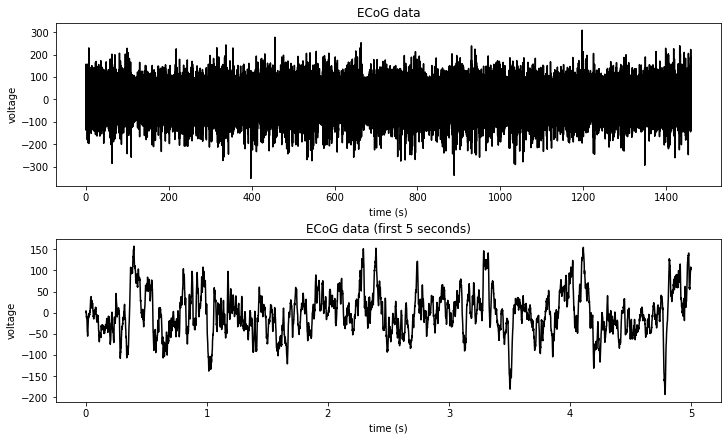

In [5]:
# visulatize time-series

# create time vector
time_vector = create_times(n_seconds, fs)

# plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[10,6], constrained_layout=True)
ax1.set_title("ECoG data")
ax1.plot(time_vector, data, color='k') # plot all data
ax2.set_title("ECoG data (first 5 seconds)")
ax2.plot(time_vector[:5*fs], data[:5*fs], color='k') # plot first 5 seconds
for ax in [ax1, ax2]:
    ax.set(xlabel="time (s)", ylabel="voltage")
plt.show()

### Visualize example tapers
Discrete prolate spheroidal sequences (dpss) or Slepian sequences

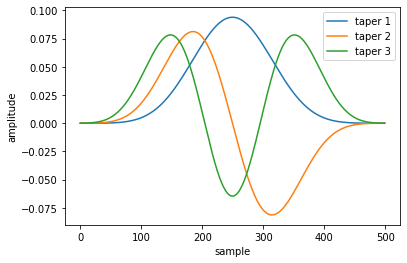

In [6]:
# visualize example tapers

# define parameters
window_length = int(0.5 * fs) # in samples
half_bandwidth = 5 # in Hz
n_tapers = 3 # number of tapers

# compute tapers
tapers = dpss(window_length, half_bandwidth, Kmax=n_tapers)

# plot tapers
fig, ax = plt.subplots(1,1, figsize=[6,4])
for i_taper, taper in enumerate(tapers):
    ax.plot(taper, label=f"taper {i_taper+1}")
ax.set(xlabel="sample", ylabel="amplitude")
ax.legend()

### Compute multitaper - example I
Here we apply the multitaper method to empirical iEEG data. This example leveraged the MNE implementation of the multitaper method [(documentation)](https://mne.tools/stable/generated/mne.time_frequency.tfr_array_multitaper.html).

In [7]:
# apply multitaper method

# reshape data for MNE function (n_epochs, n_channels, n_times)
epoch_data = data.reshape(1, 1, -1)

# take first 60 seconds of data only (for speed)
epoch_data = epoch_data[..., :60*fs]
time = time_vector[:60*fs]

# define frequencies of interest
freq = np.arange(1, 100, 1)

# compute spectrogram
tfr = tfr_array_multitaper(epoch_data, sfreq=fs, freqs=freq, output='power')
tfr = tfr[0,0] # reshape: remove extra dimensions

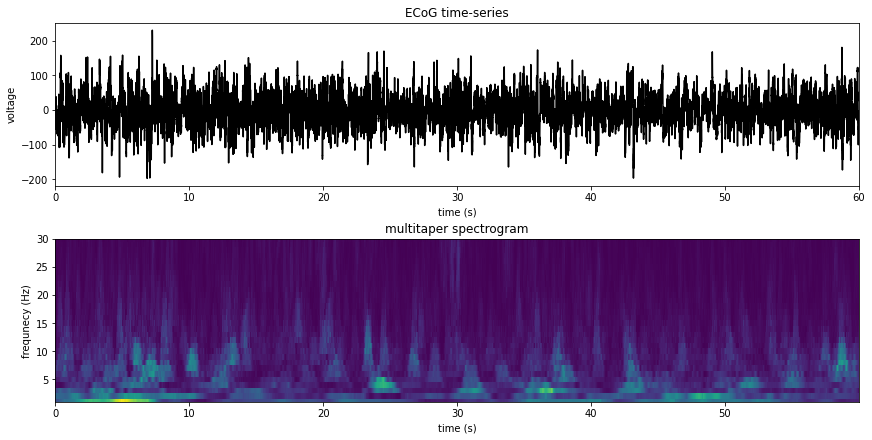

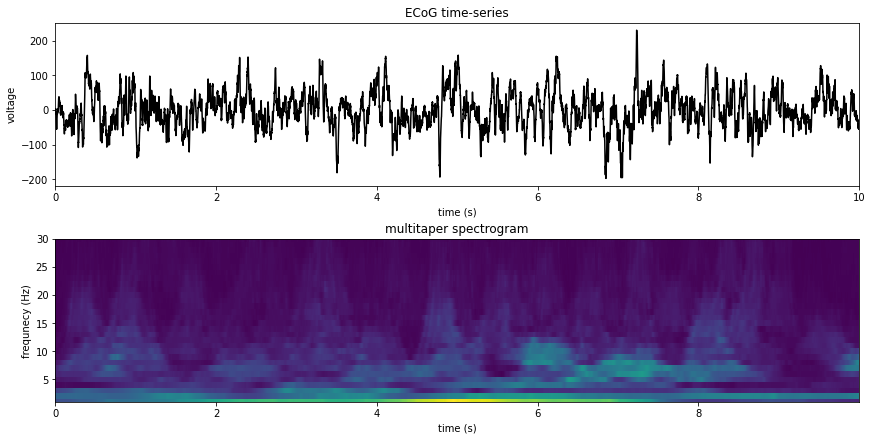

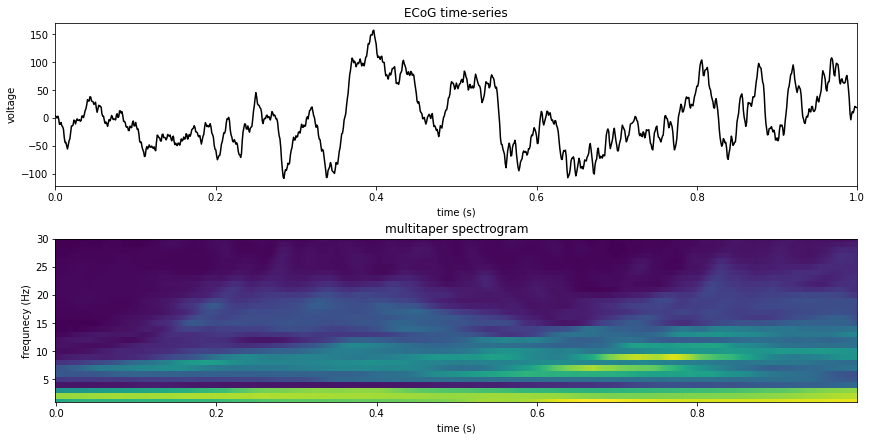

In [8]:
# plot results 

for duration in [60, 10, 1]: # plot 60, 10, and 1 seconds of data
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=[12,6], constrained_layout=True)

    # plot time-series
    ax0.plot(time[:duration*fs], data[:duration*fs], color='k')
    ax0.set(xlabel="time (s)", ylabel="voltage")
    ax0.set_title("ECoG time-series")
    ax0.set_xlim(0, duration)

    # plot spectra
    ax1.pcolormesh(time[:duration*fs], freq, tfr[:,:duration*fs])
    ax1.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
    ax1.set_title("multitaper spectrogram")
    ax1.set_ylim(1, 30)
    plt.show()

### Compute multitaper - example II (Event-related analysis)
Here we extend our the analysis from example I by computing the average spectral power around a series of events (standard stimuli presentation times).

In [9]:
# define helper functions for spectrogram plotting 

def plot_tfr(tfr, freqs, time, title=None, y_units="$\u00B5V^2/Hz$"):
    """
    Plot time-frequency representation (TFR) of power (i.e. spectrogram).
    """
    
    # imports
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import LogNorm

    # settings
    cmap = 'viridis'
    norm = LogNorm(vmin=np.min(tfr), vmax=np.max(tfr))

    # plot
    _fig, ax = plt.subplots(1,1, figsize=[12, 6], constrained_layout=True)
    ax.pcolormesh(time, freqs, tfr, cmap=cmap, norm=norm)
    ax.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
    ax.axvline(0, color='k', linestyle='--')
    fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax, 
                 label=f"power ({y_units})")
    if title:
        ax.set_title(title)


def plot_evoked_tfr(tfr, freqs, time, title=None):
    """
    Plot evoked spectrogram. Normalize power at each frequnecy to highlight
    event-related dynamics. Power values are z-scored across time, then
    the average baseline power is subtracted before plotting.
    """

    # normalize power at each frequency by taking z-score across time
    tfr  = zscore_tfr(tfr)

    # subtract baseline power at each frequency
    tfr = subtract_baseline(tfr, time)

    # plot normalized spectrogram
    fig, ax = plt.subplots(1,1, figsize=[12, 6], constrained_layout=True)
    ax.pcolormesh(time, freqs, tfr, cmap='coolwarm', 
                norm=TwoSlopeNorm(vcenter=0))
    ax.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
    ax.axvline(0, color='k', linestyle='--')
    fig.colorbar(ax.pcolormesh(time, freqs, tfr, cmap='coolwarm', 
                               norm=TwoSlopeNorm(vcenter=0)), ax=ax,
                               label="normalized power (au)")
    if title:
        ax.set_title(title)


def zscore_tfr(tfr):
    """
    Normalize time-frequency representation (TFR) by z-scoring each frequency.
    TFR should be 2D (frequency x time).

    Parameters
    ----------
    tfr : 2D array
        Time-frequency representation of power (spectrogram).

    Returns
    -------
    tfr_norm : 2D array
        Z-score normalized TFR.
    """

    # define z-score function
    def zscore(signal):
        return (signal - np.mean(signal)) / np.std(signal)
    
    # z-score normalize 
    tfr_norm = np.zeros_like(tfr)
    for i_freq in range(tfr.shape[0]):
        tfr_norm[i_freq] = zscore(tfr[i_freq])
        
    return tfr_norm


def subtract_baseline(signals, time, t_baseline=None):
    """
    Subtract baseline from signals. Baseline is defined as the mean of the
    signal between t_baseline[0] and t_baseline[1]. Signals should be 2D
    (signals x time).

    Parameters
    ----------
    signals : 2D array
        Signals to be baseline corrected.
    time : 1D array
        Time vector.
    t_baseline : 1D array
        Time range for baseline (t_start, t_stop). If None, the baseline is
        defined as all time points before time 0.

    Returns
    -------
    signals_bl : 2D array
        Baseline corrected signals.
    """
    
    # create mask for baseline time range
    if t_baseline is None:
        t_baseline = (time[0], 0)
    mask_bl = ((time>t_baseline[0]) & (time<t_baseline[1]))
    
    # subtract baseline from each signal
    signals_bl = np.zeros_like(signals)
    for ii in range(len(signals)):
        signals_bl[ii] = signals[ii] - np.mean(signals[ii, mask_bl])
    
    return signals_bl


def crop_tfr(tfr, time, time_range):
    """
    Crop time-frequency representation (TFR) to a specified time range.
    TFR can be mulitdimensional (time must be last dimension).

    Parameters
    ----------
    tfr : array
        Time-frequency representation of power (spectrogram).
    time : 1D array
        Associated time vector (length should be equal to that of
        the last dimension of tfr).
    time_range : 1D array
        Time range to crop (t_start, t_stop).

    Returns
    -------
    tfr, time : array, array
        Cropped TFR and time vector.
    """
    
    tfr = tfr[..., (time>time_range[0]) & (time<=time_range[1])]
    time = time[(time>time_range[0]) & (time<=time_range[1])]
    
    return tfr, time


In [10]:
# epoch data around standard stimuli

# initialize array to store epochs
t_window = [-1.25, 1.25] # window around standard stimuli
n_samples = int(np.diff(t_window) * fs) # number of samples in window
n_events = len(sta) # number of events
epoch_data = np.zeros((n_events, n_samples))

# loop through events and eposh data
for i_event, event_index in enumerate(sta):
    epoch_data[i_event] = data[int(event_index + t_window[0]*fs) : \
                               int(event_index + t_window[1]*fs)]

print(f"Shape of epoch_data:\t{epoch_data.shape}")
print(f"Number of events:\t{n_events} events")
print(f"Epoch duration:\t\t{n_samples/fs} seconds")

Shape of epoch_data:	(380, 2500)
Number of events:	380 events
Epoch duration:		2.5 seconds


In [11]:
# apply multitaper method

# multitaper analysis settings
window_length = 0.5 # in seconds (duration of windows for multitaper analysis)
freq_bandwidth = 4 # in Hz (frequencies at +/- freq_bandwidth will be smoothed)
freqs = np.arange(2, 101, 1) # frequencies at which to compute power
n_cycles = freqs * window_length # use a fixed window length for all freqs
time_bandwidth = int(window_length * freq_bandwidth) # must be >= 2

# compute TFR
epoch_data_3d = epoch_data[np.newaxis, :] # reshape for MNE function
tfr = tfr_array_multitaper(epoch_data_3d, sfreq=fs, freqs=freqs, 
                           n_cycles=n_cycles, time_bandwidth=time_bandwidth, 
                           output='power', n_jobs=-1)
tfr = np.log10(tfr[0]) # log-transform power and remove extra dimension
tfr_mean = tfr.mean(axis=0) # average over epochs

# crop edge effects
event_time_vector = create_times(n_samples/fs, fs, start_val=t_window[0])
time_range = [t_window[0]+window_length/2, t_window[1]-window_length/2]
tfr_mean, time = crop_tfr(tfr_mean, event_time_vector, time_range)

# interpolate line-noise range (remove effects of bandstop filter)
tfr_mean = interpolate_spectra(freqs, tfr_mean.T, [55, 65])[1].T

# print shape of results
print(f"\nShape of tfr_mean:\t{tfr_mean.shape}")
print(f"Shape of freqs:\t{freqs.shape}")
print(f"Shape of time:\t{time.shape}")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 152 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 380 out of 380 | elapsed:    5.5s finished



Shape of tfr_mean:	(99, 2000)
Shape of freqs:	(99,)
Shape of time:	(2000,)


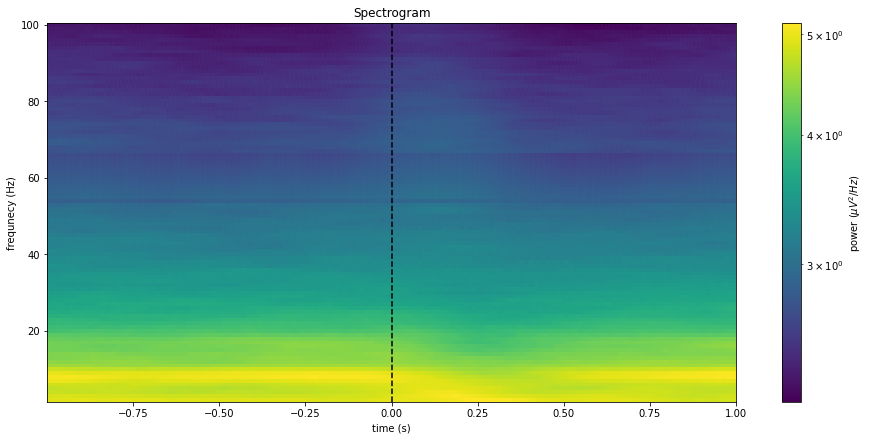

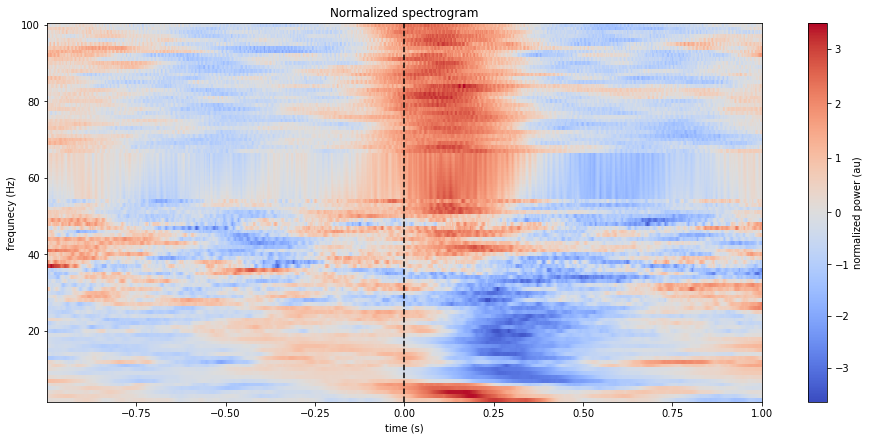

In [12]:
# plot multiaper results
plot_tfr(tfr_mean, freqs, time, title="Spectrogram")

# Plot normalized spectrogam to highlight event-related changes
plot_evoked_tfr(tfr_mean, freqs, time, title="Normalized spectrogram")

In [13]:
# # repeat for target stimuli

# tfr_sta = tfr_mean.copy() # save standard stimuli TFR for comparison

# # epoch data around target stimuli
# epochs_tar = np.zeros((len(tar), n_samples))
# for i_event, event_index in enumerate(tar):
#     epochs_tar[i_event] = data[int(event_index + t_window[0]*fs) : \
#                                int(event_index + t_window[1]*fs)]

# # compute TFR
# tfr = tfr_array_multitaper(epochs_tar[np.newaxis, :], sfreq=fs, freqs=freqs, 
#                            n_cycles=n_cycles, time_bandwidth=time_bandwidth, 
#                            output='power', n_jobs=-1)
# tfr = np.log10(tfr[0]) # log-transform power and remove extra dimension
# tfr_tar = tfr.mean(axis=0) # average over epochs
# tfr_tar, _ = crop_tfr(tfr_tar, event_time_vector, time_range) # crop edge effects
# tfr_tar = interpolate_spectra(freqs, tfr_tar.T, [55, 65])[1].T # interpolate line-noise range

# # plot results
# plot_evoked_tfr(tfr_sta, freqs, time, title="Standard stimuli")
# plot_evoked_tfr(tfr_tar, freqs, time, title="Target stimuli")



### Compare to other time-resolved spectral estimation techniques (STFT and wavelet)

Window size: 64 samples
Number of frequencies: 33
Number of time steps: 79


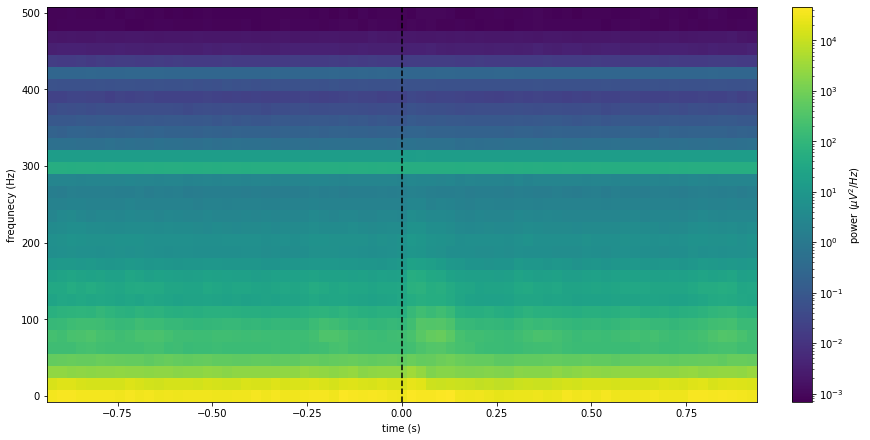

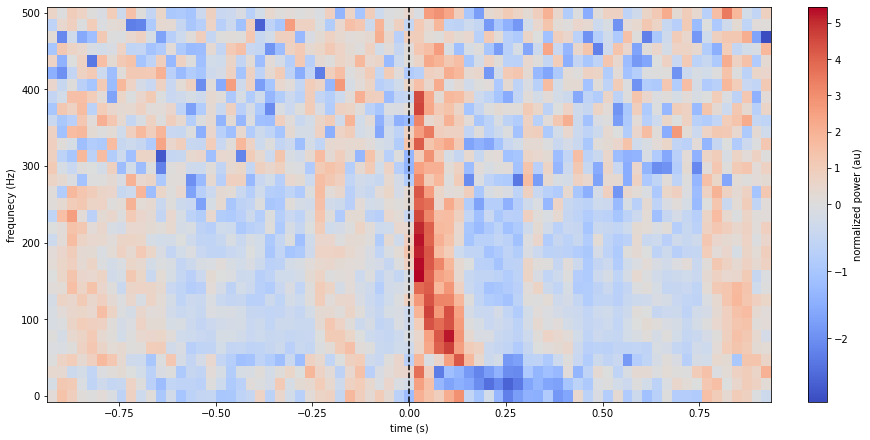

In [14]:
# demo short-time Fourier transform (STFT)

# settings
wsize = 64 # in samples (STFT window size). Must be multiple of 4
tstep = int(wsize / 2) # in samples (STFT step size). Here we use 50% overlap
print(f"Window size: {wsize} samples")

# compute STFT
stft_coef = stft(epoch_data, wsize, tstep=tstep)
stft_power = np.abs(stft_coef)**2 # compute power
stft_power = np.mean(stft_power, axis=0) # average over epochs

# compute corresponding time and frequency vector
stft_freq = stftfreq(wsize, fs)
stft_time = np.linspace(time_range[0], time_range[1], stft_power.shape[1])

# drop edge
edge_mask = np.logical_and(stft_time>=time_range[0]+wsize/fs, stft_time<=time_range[1]-wsize/fs)
stft_power = stft_power[:, edge_mask]
stft_time = stft_time[edge_mask]

# plot results
plot_tfr(stft_power, stft_freq, stft_time)
plot_evoked_tfr(stft_power, stft_freq, stft_time)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 380 out of 380 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 380 out of 380 | elapsed:    3.0s finished


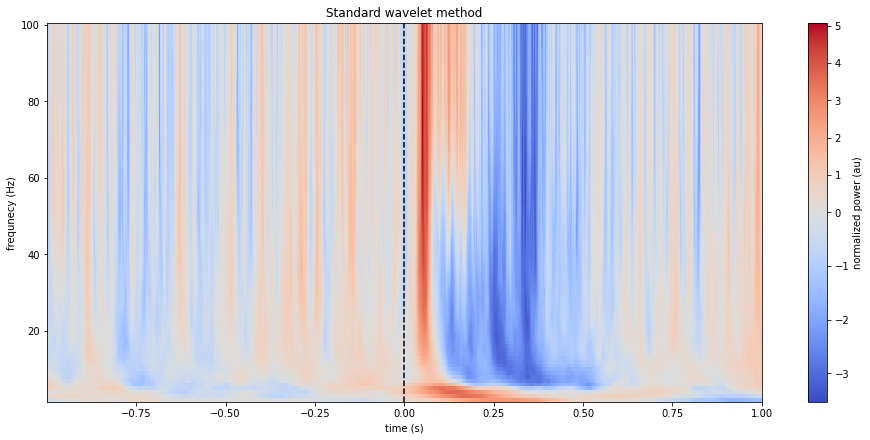

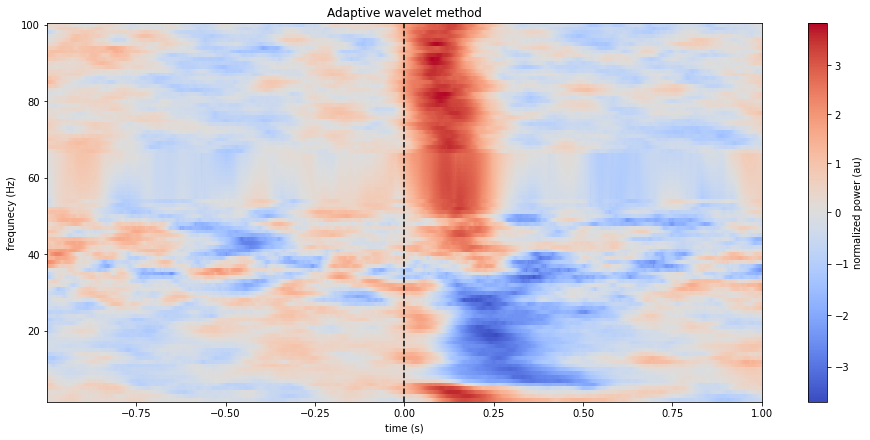

In [15]:
# demo wavelet method

# settings - match to multitaper method above
freqs = np.arange(2, 101, 1)
window_length = 0.5 # used in adaptive wavelet method only

# demo standard wavelet method - use a fixed number of cycles at each frequency
tfr = tfr_array_morlet(epoch_data[np.newaxis, :], sfreq=fs, freqs=freqs,
                       n_cycles=2, output='power', n_jobs=-1)
tfr = np.mean(np.log10(tfr[0]), axis=0) # average over epochs
tfr, _ = crop_tfr(tfr, event_time_vector, time_range) # crop edge effects
tfr = interpolate_spectra(freqs, tfr.T, [55, 65])[1].T # interpolate line-noise range
plot_evoked_tfr(tfr, freqs, time, title="Standard wavelet method") 

# demo adaptive wavelet method - use a fixed window size, as in multitaper method
n_cycles = freqs * window_length
tfr = tfr_array_morlet(epoch_data[np.newaxis, :], sfreq=fs, freqs=freqs,
                       n_cycles=n_cycles, output='power', n_jobs=-1)
tfr = np.log10(tfr[0])
tfr = tfr.mean(axis=0)
tfr, _ = crop_tfr(tfr, event_time_vector, time_range)
tfr = interpolate_spectra(freqs, tfr.T, [55, 65])[1].T
plot_evoked_tfr(tfr, freqs, time, title="Adaptive wavelet method")


The "standard" and "adaptive" Morlet decomposition methods are powerful tools for computing time-resolved estimates of spectral power. The standard method uses a fixed number of oscillatory cycles at each frequency, while the adaptive method uses a fixed window size at each frequency. In this demonstration, the difference between these two methods is most evident at high frequencies; while the standard method has high temporal resolution but more frequency smoothing, the adaptive method has high frequency resolution but more temporal smoothing, highlighting the time-frequency trade-off of spectral analysis. If one aims to perform time-resolved spectral parameterization, we recommend using the adaptive method so that each spectrum parameterized (i.e. each bin of the spectrogram) represents the same duration of time across all frequencies.

### Recommendations

We recommend using either the multitaper method or the adaptive wavelet method for computing spectral power for short time windows. The specific decomposition method, and associated hyperparamters, largely depends on the research question. In general, wavelet decomposition has greater temporal resolution while multitaper decomposition has greater freqeuncy resolution. As with many other methodological choices, we recommend running a sensitivity analysis to ensure results are not dependent on the chosen decomposition method or hyperparameters. 

### Conclusion

<>